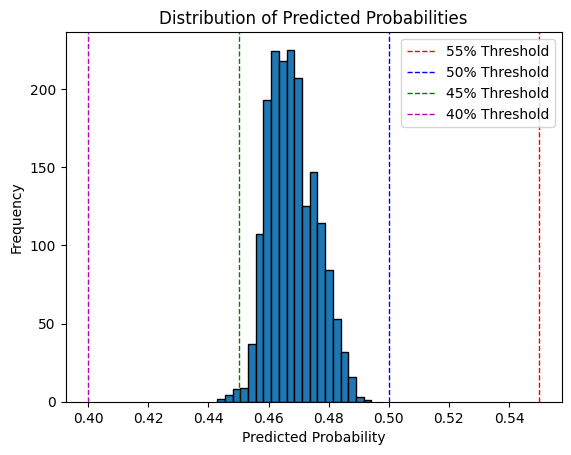

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Load the dataset
file_path = '../analyze/zigzagStrategy.d/top1000.csv.gz'
df = pd.read_csv(file_path)


# Encode the target variable
df['result'] = df['result'].map({'win': 1, 'lose': 0})

# Split the data into features (X) and target (y)
X = df.drop(columns=['result'])
y = df['result']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models with the best hyperparameters
rf_model = RandomForestClassifier(n_estimators=200, max_depth=15, min_samples_split=5, min_samples_leaf=2)
gb_model = GradientBoostingClassifier(n_estimators=150, max_depth=4, learning_rate=0.01, min_samples_split=5, min_samples_leaf=2)
svm_model = SVC(probability=True)
knn_model = KNeighborsClassifier()

# Create a stacking classifier
stacking_clf = StackingClassifier(
    estimators=[
        ('rf', rf_model), 
        ('gb', gb_model), 
        ('svm', svm_model), 
        ('knn', knn_model)
    ], 
    final_estimator=LogisticRegression(max_iter=1000)
)

# Create a pipeline for the stacking classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', stacking_clf)
])

# Fit the final model on the entire dataset
pipeline.fit(X, y)

# Predict probabilities on the entire dataset
probabilities = pipeline.predict_proba(X)[:, 1]  # Probability of the positive class (win)

# Plot the distribution of predicted probabilities
plt.hist(probabilities, bins=20, edgecolor='k')
plt.axvline(0.55, color='r', linestyle='dashed', linewidth=1, label='55% Threshold')
plt.axvline(0.50, color='b', linestyle='dashed', linewidth=1, label='50% Threshold')
plt.axvline(0.45, color='g', linestyle='dashed', linewidth=1, label='45% Threshold')
plt.axvline(0.40, color='m', linestyle='dashed', linewidth=1, label='40% Threshold')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.legend()
plt.show()



In [5]:
# Define thresholds for "buy" and "sell"
buy_threshold = 0.55
sell_threshold = 0.30

# Filter "buy" trades
buy_trades_to_execute = probabilities > buy_threshold
buy_filtered_trades = X[buy_trades_to_execute]
buy_filtered_y_true = y[buy_trades_to_execute]

# Calculate the accuracy on the filtered "buy" trades
if len(buy_filtered_y_true) > 0:
    buy_filtered_accuracy = (buy_filtered_y_true == 1).mean()
    print(f"Filtered Buy Accuracy with {int(buy_threshold*100)}% Threshold:", buy_filtered_accuracy)
else:
    print(f"No buy trades met the {int(buy_threshold*100)}% threshold")

# Filter "sell" trades
sell_trades_to_execute = probabilities < sell_threshold
sell_filtered_trades = X[sell_trades_to_execute]
sell_filtered_y_true = y[sell_trades_to_execute]

# Calculate the accuracy on the filtered "sell" trades
if len(sell_filtered_y_true) > 0:
    sell_filtered_accuracy = (sell_filtered_y_true == 0).mean()  # We expect these to be loses
    print(f"Filtered Sell Accuracy with {int(sell_threshold*100)}% Threshold:", sell_filtered_accuracy)
else:
    print(f"No sell trades met the {int(sell_threshold*100)}% threshold")

# Combine the trades and their actual results for analysis
if not buy_filtered_trades.empty:
    buy_filtered_results = buy_filtered_trades.copy()
    buy_filtered_results['result'] = buy_filtered_y_true.values
    print("Buy Trades:")
    print(buy_filtered_results)

if not sell_filtered_trades.empty:
    sell_filtered_results = sell_filtered_trades.copy()
    sell_filtered_results['result'] = sell_filtered_y_true.values
    print("Sell Trades:")
    print(sell_filtered_results)

No buy trades met the 55% threshold
No sell trades met the 30% threshold
